In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf

from src.utils import load, add_variables, clean_data
from src.preprocessing import DataSet
from src.forecast import ARIMA, TSCV
from src.ploting import LinearPlot, DistPlot, ACFPlot, QQPlot
from src.utils import GridSearch
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from scipy.stats import jarque_bera
from scipy import stats

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', UserWarning)

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 50)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [2]:
CURRENCY = "EURUSD"
INTERVAL = "4h"

In [3]:
eurusd = load(currency=CURRENCY, interval=INTERVAL)
data = DataSet(data=eurusd, ratios=[0.9, 0.1], label=['target_value'])
train, val, test = data.add_variables().clean_data().normalize(how="standarize").get_tvt_df()

NORMALIZING DATA!!


PACF plot of target_value variable

/Users/sebastiansukiennik/.pyenv/versions/3.9.6/envs/BACH/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


saving: 


<Axes: >

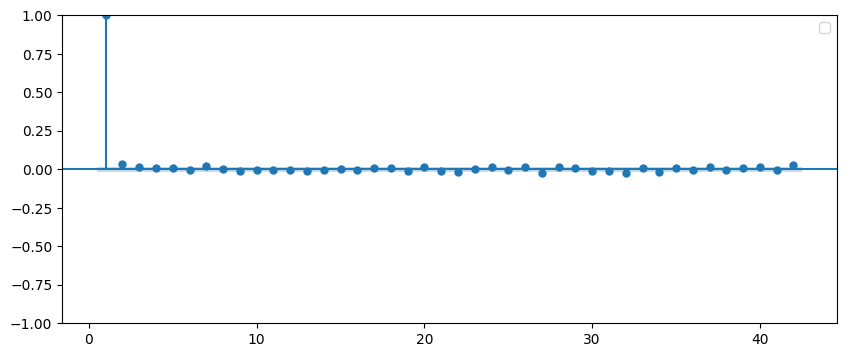

In [4]:
ACFPlot(legend=True).plot(train['target_value'], partial=True, legend="ACFPlot")

Durbin Watson test for lag 1 autocorrelation

In [7]:
durbin_watson(train['target_value'])

4.2729243e-06

ADfuller test for stationarity

In [8]:
for k in range(4):
    ts = train['target_value'].diff(k).dropna() if k !=0 else train['target_value']
    adf_res = adfuller(ts)
    print(f"k={k}, p-value: {adf_res[1]}, adf statistic: {adf_res[0]}")

k=0, p-value: 0.325144563894193, adf statistic: -1.9147710546888095
k=1, p-value: 0.0, adf statistic: -130.08637773355676
k=2, p-value: 0.0, adf statistic: -19.740014395144676
k=3, p-value: 0.0, adf statistic: -19.092713926413374


In [9]:
eurusd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24565 entries, 2011-08-17 16:00:00 to 2022-11-01 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    18050 non-null  float32
 1   Low     18050 non-null  float32
 2   High    18050 non-null  float32
 3   Close   18050 non-null  float32
 4   Volume  24565 non-null  float32
dtypes: float32(5)
memory usage: 671.7 KB


# ARIMA

In [ ]:
import time


In [6]:
eurusd = load(currency=CURRENCY, interval=INTERVAL)
eurusd = clean_data(eurusd)
data = DataSet(data=eurusd, ratios=[0.95, 0.05], label=['target_value'])
tscv = TSCV(dataset=data,
            n_splits=3,
            test_size=200)
a = ARIMA()
tscv.run(a, p=2, d=1, q=4)

split: 1/3
split: 2/3
split: 3/3

[INFO] Calculating reisduals..

(200, 1)
(400, 1)
(600, 1)
(800, 1)
(1000, 1)
(1200, 1)
(1400, 1)
(1600, 1)
(1800, 1)
(2000, 1)
(2200, 1)
(2400, 1)


KeyboardInterrupt: 

In [18]:
print(f"Average fit time: {round(tscv.avg_fit_time, 3)}, prediction time: {round(tscv.avg_pred_time, 3)}")

Average fit time: 1.751, prediction time: 0.003


In [11]:
tscv.model.model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           target_value   No. Observations:                17303
Model:                 ARIMA(2, 1, 4)   Log Likelihood               79373.032
Date:                Tue, 23 May 2023   AIC                        -158732.065
Time:                        23:25:35   BIC                        -158677.755
Sample:                             0   HQIC                       -158714.171
                              - 17303                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3029      0.002   -124.754      0.000      -0.308      -0.298
ar.L2          0.1844      0.003     55.350      0.000       0.178       0.191
ma.L1          0.2671      0.002    108.845      0.000       0.262       0.272
ma.L2         -0.2008      0.003    -59.510      0.000      -0.207      -0.194
ma.L3          0.0043      0.007      0.598      0.550      -0.010       0.018
ma.L4         -0.0041      0.007     -0.622      0.534      -0.017       0.009
sigma2      6.053e-06   2.72e-08    222.241      0.000       6e-06    6.11e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             70650.52
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.47e+16. Standard errors may be unstable.
"""

saving: ARIMA
saving: ARIMA


<Axes: title={'center': 'ARIMA'}>

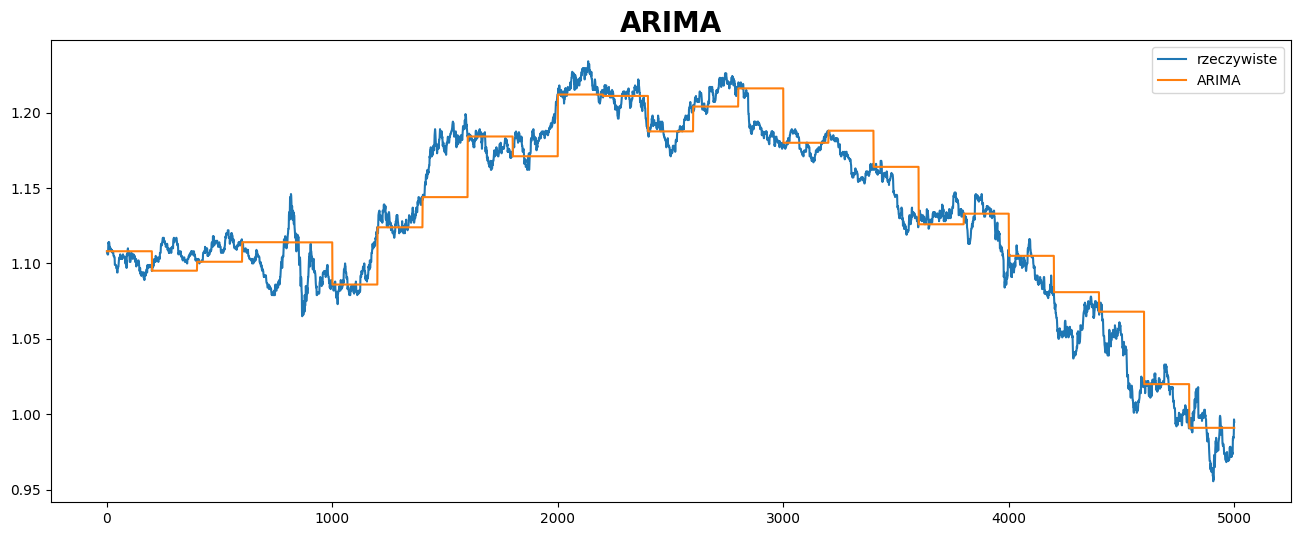

In [12]:
pred_y = tscv.predicted
x = tscv.dataset.data.index[-len(pred_y):]


lp = LinearPlot(legend=True, h=6, w=16)
lp.plot(range(len(pred_y)), tscv.dataset.data.loc[x, 'target_value'], label="rzeczywiste", title="ARIMA")
lp.plot(range(len(pred_y)), pred_y, label="ARIMA")

# GridSearch ARIMA

In [26]:
eurusd = load(currency=CURRENCY, interval=INTERVAL)
eurusd = clean_data(eurusd)
data = DataSet(data=eurusd, ratios=[0.95, 0.05], label=['target_value'])
tscv = TSCV(dataset=data,
            n_splits=25,
            test_size=200)

warnings.filterwarnings('ignore')
gs = GridSearch(model_class=ARIMA,
                tscv=tscv,
                params={'p': [1, 2, 3, 4], 'd': [1], 'q': [1, 2, 3, 4]},
                by=['rmspe'],
                p_count=5)
# gs.run() # already been run, best model: ARIMA(4, 1, 2)

split: 1/25
split: 2/25
split: 3/25
split: 4/25
split: 5/25
split: 6/25
split: 7/25
split: 8/25
split: 9/25
split: 10/25
split: 11/25
split: 12/25
split: 13/25
split: 14/25
split: 15/25
split: 16/25
split: 17/25
split: 18/25
split: 19/25
split: 20/25
split: 21/25
split: 22/25
split: 23/25
split: 24/25
split: 25/25

[INFO] Calculating reisduals..

split: 1/25
split: 2/25
split: 3/25
split: 4/25
split: 5/25
split: 6/25
split: 7/25
split: 8/25
split: 9/25
split: 10/25
split: 11/25
split: 12/25
split: 13/25
split: 14/25
split: 15/25
split: 16/25
split: 17/25
split: 18/25
split: 19/25
split: 20/25
split: 21/25
split: 22/25
split: 23/25
split: 24/25
split: 25/25

[INFO] Calculating reisduals..

split: 1/25
split: 2/25
split: 3/25
split: 4/25
split: 5/25
split: 6/25
split: 7/25
split: 8/25
split: 9/25
split: 10/25
split: 11/25
split: 12/25
split: 13/25
split: 14/25
split: 15/25
split: 16/25
split: 17/25
split: 18/25
split: 19/25
split: 20/25
split: 21/25
split: 22/25
split: 23/25
split: 24/25

# Model evaluation

In [8]:
tscv = TSCV(dataset=data,
            n_splits=25,
            test_size=200)
tscv.run(ARIMA(), p=4, d=1, q=2)

split: 1/25
split: 2/25
split: 3/25
split: 4/25
split: 5/25
split: 6/25
split: 7/25
split: 8/25
split: 9/25
split: 10/25
split: 11/25
split: 12/25
split: 13/25
split: 14/25
split: 15/25
split: 16/25
split: 17/25
split: 18/25
split: 19/25
split: 20/25
split: 21/25
split: 22/25
split: 23/25
split: 24/25
split: 25/25

[INFO] Calculating reisduals..

(200, 1)
(400, 1)
(600, 1)
(800, 1)
(1000, 1)
(1200, 1)
(1400, 1)
(1600, 1)
(1800, 1)
(2000, 1)
(2200, 1)
(2400, 1)
(2600, 1)
(2800, 1)
(3000, 1)
(3200, 1)
(3400, 1)
(3600, 1)
(3800, 1)
(4000, 1)
(4200, 1)
(4400, 1)
(4600, 1)
(4800, 1)
(5000, 1)
(5200, 1)
(5400, 1)
(5600, 1)
(5800, 1)
(6000, 1)
(6200, 1)
(6400, 1)
(6600, 1)
(6800, 1)
(7000, 1)
(7200, 1)
(7400, 1)
(7600, 1)
(7800, 1)
(8000, 1)
(8200, 1)
(8400, 1)
(8600, 1)
(8800, 1)
(9000, 1)
(9200, 1)
(9400, 1)
(9600, 1)
(9800, 1)
(10000, 1)
(10200, 1)
(10400, 1)
(10600, 1)
(10800, 1)
(11000, 1)
(11200, 1)
(11400, 1)
(11600, 1)
(11800, 1)
(12000, 1)
(12200, 1)
(12400, 1)
(12600, 1)
(12800, 1)


({'mean_absolute_percentage_error': 0.01454653508250633,
  'rmspe': 0.01971853840664553,
  'mean_absolute_error': 0.017102017848681535},
 {'mean_absolute_percentage_error': 0.012283006940518539,
  'rmspe': 0.01459178618552456,
  'mean_absolute_error': 0.013708905786257403})

In [9]:
resid = tscv.model.model_fit.resid[1:]

### Residuals distribution

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


saving: 
saving: 


<Axes: xlabel='Czas', ylabel='Wielkość reszt'>

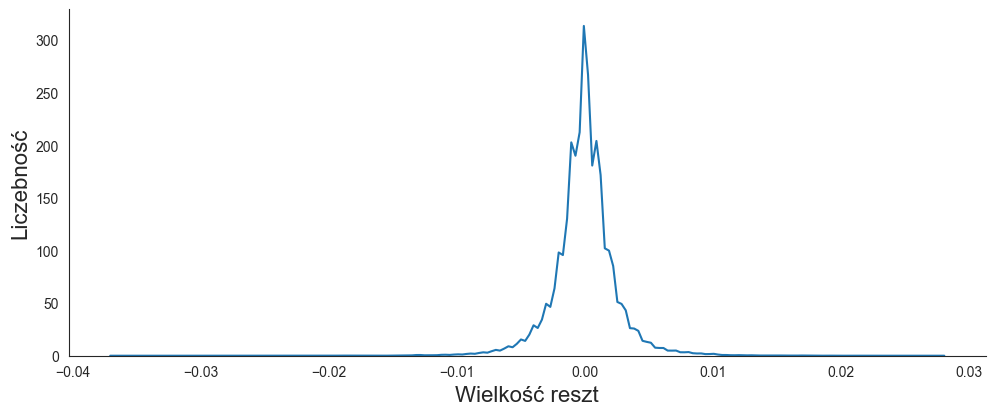

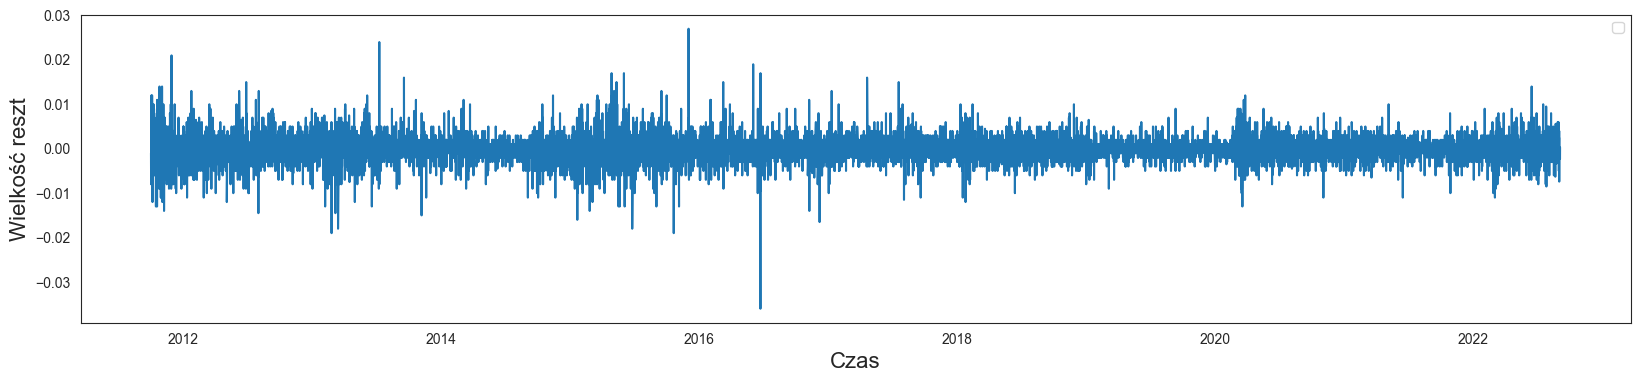

In [11]:
DistPlot().plot(resid, xlabel="Wielkość reszt", ylabel="Liczebność")
LinearPlot(w=20).plot(tscv.dataset.train.index[1:], resid, xlabel="Czas", ylabel="Wielkość reszt")

In [30]:

jarque_bera(resid)

SignificanceResult(statistic=70511.02797868442, pvalue=0.0)

In [31]:
ind = np.argpartition(np.abs(resid), -100)[-100:]
top_100 = resid[ind].sort_index()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


saving: Rozkład reszt ARIMA
saving: Wykres liniowy reszt ARIM


<Axes: title={'center': 'Wykres liniowy reszt ARIM'}>

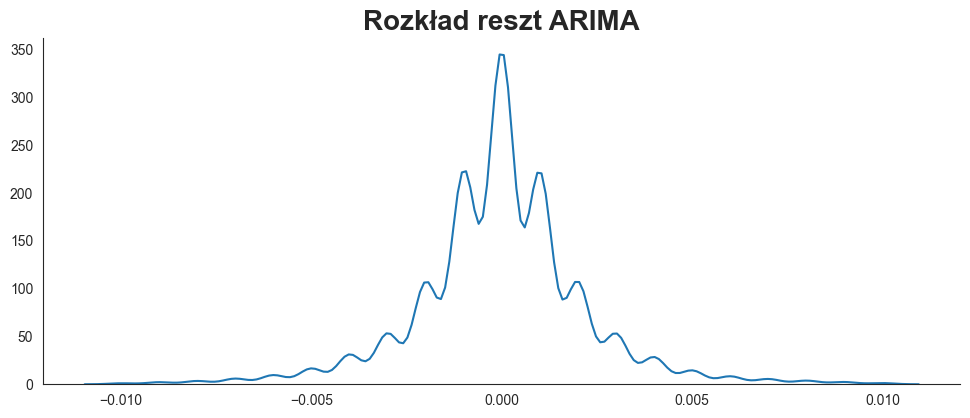

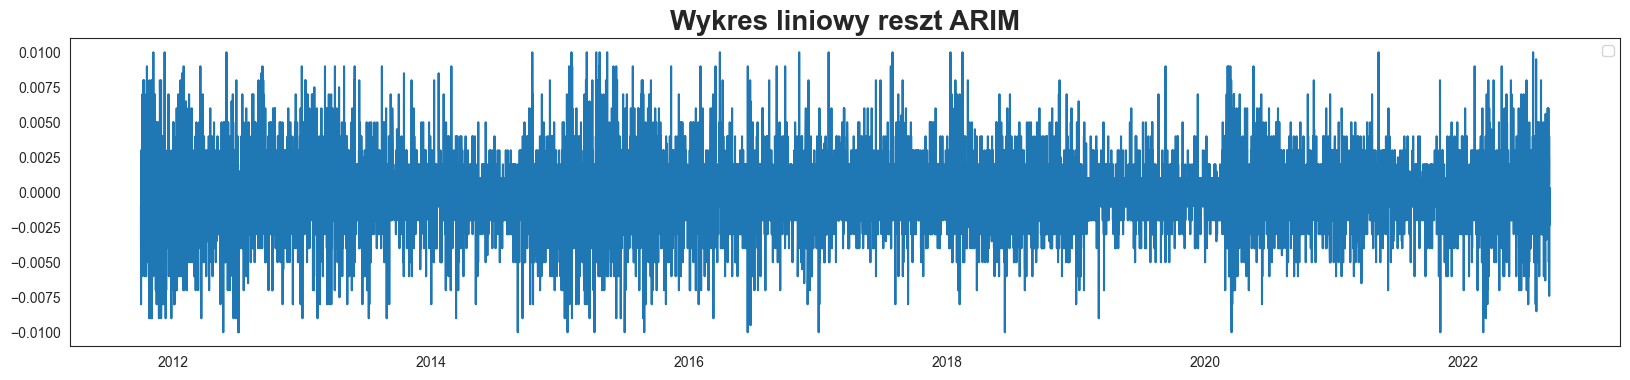

In [32]:
r_2 = resid.drop(index=top_100.index)
DistPlot().plot(r_2, title="Rozkład reszt ARIMA")
LinearPlot(w=20).plot(r_2.index, r_2, title="Wykres liniowy reszt ARIM")

In [33]:
jarque_bera(resid)

SignificanceResult(statistic=70511.02797868442, pvalue=0.0)

In [34]:
print(f"skewenes: {stats.skew(resid)}\nkurtosis: {stats.kurtosis(resid)}")

skewenes: -0.04015499581737033
kurtosis: 9.889439328015682


### Residuals autocorrelation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/sebastiansukiennik/.pyenv/versions/3.9.6/envs/BACH/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


saving: 
saving: 


<Axes: xlabel='Numer opóźnienia', ylabel='Wysokość autokorelacji'>

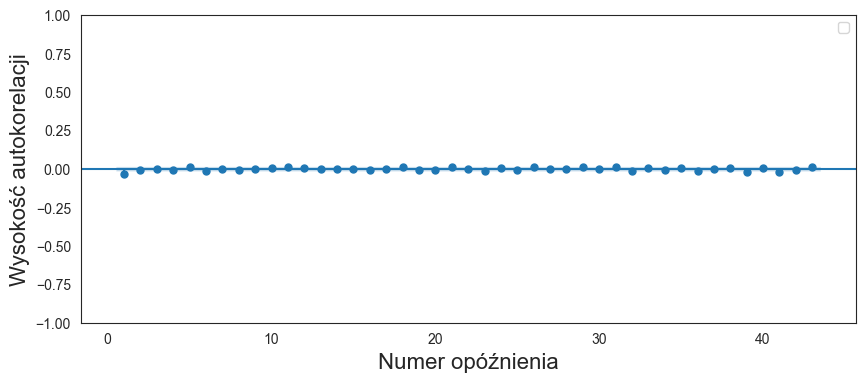

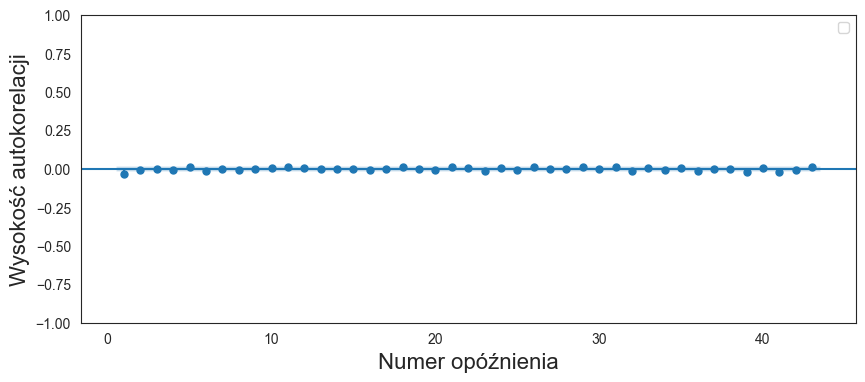

In [12]:
ACFPlot().plot(resid, xlabel="Numer opóźnienia", ylabel="Wysokość autokorelacji")
ACFPlot().plot(resid, xlabel="Numer opóźnienia", ylabel="Wysokość autokorelacji", partial=True)

In [36]:

durbin_watson(resid)

2.068986700773697

### Heteroskedasticity 

saving: Wykres kwantylowy


<Axes: title={'center': 'Wykres kwantylowy'}, xlabel='Reszty teoretyczne', ylabel='Reszty rzeczywiste'>

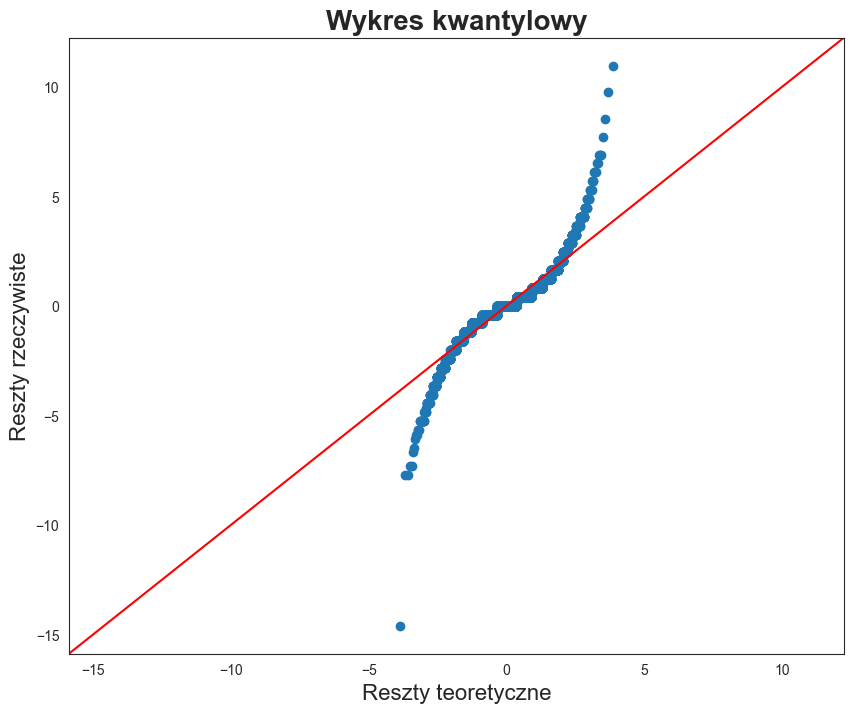

In [37]:
QQPlot(legend=False, w=10, h=8).plot(resid, xlabel="Reszty teoretyczne", ylabel="Reszty rzeczywiste")

In [38]:
het_breuschpagan(resid, tscv.dataset.train[['Close', 'target_value']].iloc[1:])

(1350.6119375915334,
 1.1342217322883555e-295,
 732.39978956432,
 4.718410566799419e-306)